Simulating a Random Walk
===============

Introduction
-----------
Very often in physics, we find ourselves needing to approximate some quantity of interest. If analytic methods fail, we may turn to numerical simulation. A large class of such algorithms goes by the name of [Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method). Some of the original algorithms in this field date to the work of von Neumann and Ulam during the Manhattan Project.

Briefly, Monte Carlo allows us to approximate a quantity of interest by _random sampling_. In this lesson, we simulate the behavior of a simple random walk.


Random Walks
---------

One of the simplest random walks we could consider goes like this:

* At time $t=0$, start the walker in position $X_{0} = 0$.

* For each timestep in $[1,2,3,\cdots, T]$, update the position as
$$X_{t} = X_{t-1} + \Delta_{j}$$
where $\Delta_{j}$ is a random variable satisfying

$$\Delta_{j} =\begin{cases}+1~~~~~\text{with probability $p$} \cr -1~~~~\text{with probability $1-p$}\end{cases}$$

That is, the direction the walker moves is determined by the outcome of a coin whose probability of coming up heads is $p$.

Notice that $X_{t}$ may be simply written as

$$X_{t} = \sum_{j=1}^{t}\Delta_{j}$$

In addition, $X_{T}$ is the total _displacement_ of the walker after $T$ timesteps.

We will be interested in simulating several properties of this walk:

**Trajectories**

A _trajectory_ of the walk is simply a collection of values for $X_{t}$. For fixed values of $p$ and $T$, what kind of trajectories do we see?

**Mean Displacement**

What is the behavior of $\langle X_{T} \rangle$ -- where we average of many trajectories -- as a function of $p$ and $T$?


**Variance of the Displacement**

What is the behavior of $(\Delta X_{T})^{2} = \langle X_{T}^{2}\rangle - \langle X_{T}\rangle^{2}$ as a function of $p$ and $T$?


**How do I do these simulations quickly?**

We'll write progressively more efficient code to do the simulations, as measured by the amount of time it takes us to compute an answer. Along the way, we will see how [_vectorization_ of our code](https://en.wikipedia.org/wiki/Array_programming) gives us significant speedups. 

Preliminaries
===========

For this lesson, we rely on ``numpy``, ``matplotlib``, and ``seaborn``. We will also be using some of the [iPython magic commands](http://ipython.readthedocs.io/en/stable/interactive/magics.html?highlight=magic).

In [7]:
'''
Import numpy, matplotlib, and seaborn.
Don't forget to use the magic %matplotlib inline
to render the figures inside the notebook!
'''

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

Building a Simulator
=============
My first intuition about how to do this simulation revolved around figuring out how to compute single trajectories. One of the more obvious ways of doing so would go as follows:

* Fix a value for the coin's bias.
* Initialize the displacement of the walker to be zero.
* For each timestep, flip a coin. If it comes up heads, increment the displacement by one; else, decrement it by one. Store the new value of the displacement in a list.
* To obtain multiple trajectories, repeat the two steps above many times.
* To obtain multiple trajectories for different values of the bias, repeat the four steps above multiple times.

Below we code up this approach by building several different functions:

* `convert_value`: Converts the outcome of a binomial experiment to $\pm 1$.
* `single_update`: Draws a random value for the step $\Delta$
* `single_trajectory`: Computes a single trajectory for a walk
* `multiple_trajectories`: Computes many trajectories

Finally, we use the iPython magic ``%%time`` to qualitatively examine what happens to the runtime of the code as we iterate over $p,T$, and the number of trajectories we simulate.




Approach I: (Many) Nested ``for`` loops
====

The most straightforward approach is to write a whole bunch of ``for`` loops.


In [112]:
def convert_value(value):
    r'''
    Maps the given value to 1 or -1.
    
    Inputs
    ------
    value: A value to be converted. Can be float or integer. 
           To obtain expected behavior, value must be either 0 or 1
    
    Returns
    ---------
    converted_value: The value converted to 1 or -1, 
                    where value = 0 is converted to -1, and 
                    value = 1 is converted to 1
    '''
    
    converted_value = value - 1 +  max(0, value) 
    return converted_value

In [113]:
def single_update(p):
    r'''Computes a single step $Delta$ for the random walk
    
    
    Inputs
    ------
    p: The bias of the coin determining the random walk
    
    Returns
    -------
    step: A random step whose distribution is
          +1 with probability p, and
          -1 with probability (1-p) 
    '''
    
    val = np.random.binomial(1, p)
    
    step = convert_value(val)
    
    return step

In [114]:
def single_trajectory(p, T, Seed):
    r'''
    Computes a single trajectory of a random walk
    
    Inputs
    ------
    p: The bias of the coin determining the random walk
    
    T: The total number of timesteps. Must be an integer.
    
    Seed: A seed for numpy's random number generator. Must be an integer
    
    Returns
    ------
    displacements: A numpy array with one row and T columns whose j^th entry
                      is the displacement of the random walker at timestep j
    '''
    
    stepList = []
    displacement = 0
    np.random.seed(Seed)
    for j in list(range(T)):
        displacement += single_update(p)
        stepList.append(displacement)
        
    return np.array(stepList)

In [131]:
def multiple_trajectories(p, T, numTrajectories):
    r'''
    Simulates multiple trajectories of a random walk
    
    Inputs
    ------
    p: The bias of the coin determining the random walk
    
    T: The total number of timesteps. Must be an integer.
    
    numTrajectories: The total number of trajectories to simulate. Must be an integer
    
    Returns
    ------
    trajectories_list: A numpy array of length numTrajectories whose j^th element is the j^th simulated trajectory
                       (which is itself of length T)
    '''
    trajectories_list = []
    
    for j in list(range(numTrajectories)):
        trajectories_list.append(single_trajectory(p, T, j))
        
    return trajectories_list

Now that we have a simulator for our random walk, let's check out how long it tends to take to run it!

In [132]:
%%time

x = multiple_trajectories(.99, 1000, 500)

CPU times: user 1.21 s, sys: 64 ms, total: 1.27 s
Wall time: 1.24 s


Even though the code seems "fast" for simulating a single trajectory, if we wanted to iterate over many different values of $p$, those times would add up. Looking back through the code, we see there are 2 ``for`` loops. Generally speaking, the more ``for`` loops you have, the slower your code will run. This has less to do with ``for`` somehow intrinsically taking a long time to execute in Python, and more to do with the fact that ``for`` loops run for as long as you let them. So if we simulate longer and longer walks, or want to create more and more trajectories, the ``for`` loops are going to cause a signficant increase in runtime.

If we wanted to compute $M$ trajectories, each of length $T$, for $P$ values of $p$, then the total runtime of our code above would scale as $\mathcal{O}(MPT)$.

While it would be good to use a tool (such as a line profiler) to check where exactly the code takes a long time to execute, an inspection of it suggests at least one way to speed up the computation, and that's by improving the performance of ``single_trajectory``. It's to that problem that we now turn.

Approach II - Vectorizing ``single_trajectory``
----------------------

The two lowest-level functions we use are ``convert_value`` and ``single_trajectory``. If we can speed up the runtimes of those two functions, then we can gain some speed advantage.

To do so, we utilize ``numpy`` array objects, which provide a more restricted kind of data type than a Python list. Using these arrays provides us with (at least) two benefits:

* We may use _vectorized_ operations. If I have two arrays, $a$ and $b$, calling $a+b$ does element-wise addition. In contrast, Python lists do not support such an operation. Further, numpy comes with many functions which can be applied to numpy arrays (for example, the sine and cosine functions), and which are evaluated in an efficient manner. (MATLAB offers similar functionality.)

* We may use [array _broadcasting_](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) to efficiently do simple scalar operations on arrays. For example, taking a numpy array $a$, and calling $a+1$, causes numpy to evaluate the addition _as if_ the number 1 is treated as an array whose shape is $a$.

In this section, we vectorize ``convert_value`` and ``single_trajectory``, which will speed up the code.

In [149]:
def vectorized_convert_value(value):
    r'''
    Maps  values to 1 or -1.
    
    Inputs
    ------
    value: A value to be converted. Can be float or integer,
           or a numpy array containing floats or integers.
           To obtain expected behavior, value must be either 0 or 1
    
    Returns
    ---------
    converted_value: The value converted to 1 or -1, 
                    where value = 0 is converted to -1, and 
                    value = 1 is converted to 1. If input
                    is numpy array, then output is numpy array as well.
    '''   
    
    
    return value - 1 + np.maximum(0, value)

Call ``vectorized_convert_value`` with a numpy array of zeros and ones, and see what happens!

In [153]:
vectorized_convert_value(np.array([0, 1]))

array([-1,  1])

By inputting an array, the output is also an array, whose elements are the actions of our function on the individual elements.

To vectorize ``single_trajectory``, we need to know that numpy's ``random.binomial()`` function can return an _array_ of values, not just a scalar. We access that functionality using the ``size`` keyword argument. This allows us to declare, in a single function call, the results of _all_ the coin tosses used in the simulation.

We also then use numpy's ``cumsum()`` function to compute the cumulative sum of the elemements of the array, thereby providing us with the trajectory.

In [134]:
def vectorized_single_trajectory(p, T, Seed):
    r'''
    Computes a single trajectory of a random walk
    
    Inputs
    ------
    p: The bias of the coin determining the random walk
    
    T: The total number of timesteps. Must be an integer.
    
    Seed: A seed for numpy's random number generator. Must be an integer
    
    Returns
    ------
    displacements: A numpy array with one row and T columns whose j^th entry
                      is the displacement of the random walker at timestep j
    '''
    
    np.random.seed(Seed)
    
    values = np.random.binomial(1, p, size=T)
    
    values = vectorized_convert_value(values)
    
    displacements = np.cumsum(values)
    
    return displacements

Let's check to make sure that our vectorized version gives the same trajectories as our original ``single_trajectory`` function. To do that, we create the ``check_vec`` function below.

In [154]:
def check_vec(p, T, Seed):
    r'''
    Checks whether the trajectory computed by vecotrized_single_trajectory
    agrees with that computed by single_trajectory.
    
    Inputs
    ------
    p: The bias of the coin determining the random walk
    
    T: The total number of timesteps. Must be an integer.
    
    Seed: A seed for numpy's random number generator. Must be an integer
    
    Returns
    -----
    None. Raises an AssertionError if the two trajectories disagree in any position.
    
    '''
    difference = vectorized_single_trajectory(p, T, Seed) - np.array(single_trajectory(p, T, Seed))
    
    assert np.isclose(difference, 0).all(), 'Vectorization failed'

Using ``check_vec``, we can iterate over values of $p,T$ and ``Seed`` to check if the vectorized code gives the same results.

In [136]:
for p in np.linspace(0, 1, num=10): check_vec(p, 1000, 0)

Now that we have done the check, let's re-write ``multiple_trajectories`` to use ``vectorized_single_trajectory`` instead. This amounts to a change in a single line of the code.

In [168]:
def multiple_trajectories(p, T, numTrajectories):
    r'''
    Simulates multiple trajectories of a random walk
    
    Inputs
    ------
    p: The bias of the coin determining the random walk
    
    T: The total number of timesteps. Must be an integer.
    
    numTrajectories: The total number of trajectories to simulate. Must be an integer
    
    Returns
    ------
    trajectories_list: A numpy array of length numTrajectories whose j^th element is the j^th simulated trajectory
                       (which is itself of length T)
    '''
    
    trajectories_list = []
    
    for j in list(range(numTrajectories)):
        trajectories_list.append(vectorized_single_trajectory(p, T, j))
        
    return trajectories_list

Let's go ahead and time our new ``multiple_trajectories`` function. (You should call it with the same inputs used when we timed the original version.)

In [171]:
%%time

x = multiple_trajectories(.99, 1000, 500)

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 30.4 ms


Wow! We achived some speedup simply by changing how we computed a single trajectory.

In a production environment (or because you are curious), you could create a _regression test_ which takes as input values of $p,T$, and the number of trajectories, and which outputs the runtime of the original ``multiple_trajectories`` and its vectorized version. This would be useful in case someone (such as your advisor!) wanted to know whether the changes "actually provided a speedup". Writing such a test would probably involve learning how to use a profiler of sorts, and learning more about better ways of timing code execution.

In the last part of this lesson, we will show how to vectorize ``multiple_trajectories`` itself, and in the process, eliminating the ``single_trajectories`` function entirely from the simulation. While this change may not always provide a speedup, it _does_ make the code a bit more robust and easier to follow (once you understand ``numpy`` arrays).

Approach III - Vectorizing ``multiple_trajectories``
===============

Our previous approach utilized the fact that we could declare, in a single function call, the results of all the coin flips the walker would take. We did so by changing the _size_ of the array of random variables returned by ``np.random.binomial``. However, numpy arrays are intrinsically _multi-dimensional_, meaning we can also use a single function call to obtain the results of all the coin flips __for all of the walkers__. In this way, we will have vectorized the random walk, not just over each individual trajectory, but over all the trajectories themselves!

In turn, this means we won't need to have a ``single_trajectories`` function to calculate a single trajectory - we'll compute the coin tosses and cumulative displacements for all the trajectories in a single go.

In [158]:
def multiple_trajectories(p, T, numTrajectories, startSeed=0):
    r'''
    Simulates multiple trajectories of a random walk
    
    Inputs
    ------
    p: The bias of the coin determining the random walk
    
    T: The total number of timesteps. Must be an integer.
    
    numTrajectories: The total number of trajectories to simulate. Must be an integer
    
    startSeed: A seed for numpy's random number generator. Optional.
    
    Returns
    ------
    trajectories_list: A numpy array of shape (numTrajectories,T) whose j^th row is the j^th simulated trajectory
                       (which is itself of length T)
    '''
    
    np.random.seed(startSeed)
    values = np.random.binomial(1, p, size=(numTrajectories, T))
    
    values = vectorized_convert_value(values)
    
    displacements = np.cumsum(values, axis=1)
    
    return displacements

With this single function, we've now managed to simplify our code for the random walk. Let's time it and see what we find.

In [167]:
%%time

x = multiple_trajectories(.99, 1000, 500)

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 13.9 ms


While the runtime seems to have gone down some, it's not entirely clear whether that decrease is actually significant. Again, we'd want to create a regression test to check that out, or look at the _distribution_ of runtimes for each version of ``multiple_trajectories``.

Examining the Behavior of a Random Walk
====================

Now that we have a fast simulator for our random walk, let's go back  to the questions which started us down this line of inquiry in the first place. Below, we examine the behavior of the random walk.

Characteristic Trajectories
------------

Because ``multiple_trajectories`` returns a numpy array whose rows are single trajectories, we can quickly generate plots of trajectories for fixed values of $p$ and $T$.

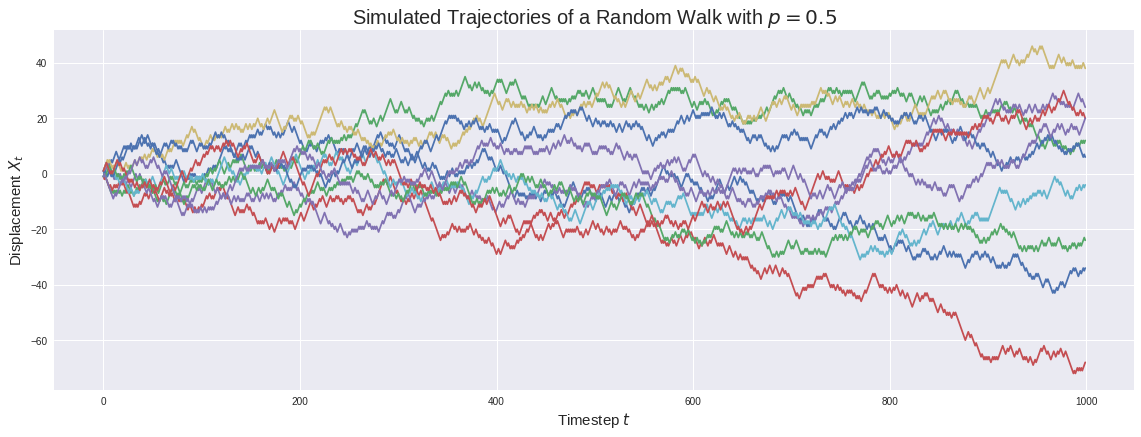

In [202]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_axes([0, 0, 1, 1])

p = .5
T = 1000

trajs = multiple_trajectories(p, T, 10)

for traj in trajs:
    ax.plot(traj)
    
ax.set_title(r'Simulated Trajectories of a Random Walk with $p={0}$'.format(p), fontsize=20)
ax.set_xlabel(r'Timestep $t$', fontsize=15)
ax.set_ylabel(r'Displacement $X_{t}$', fontsize=15)

Mean Value of the Displacement
----------------

To examine the behavior of $\langle X_{T} \rangle$, we create many trajectories, and then average over them. Again, because the output of ``multiple_trajectories`` stores each trajectory in a single _row_ of the output, we can average over the displacements at each timestep using ``np.mean``, and passing in an appropriate keyword argument.

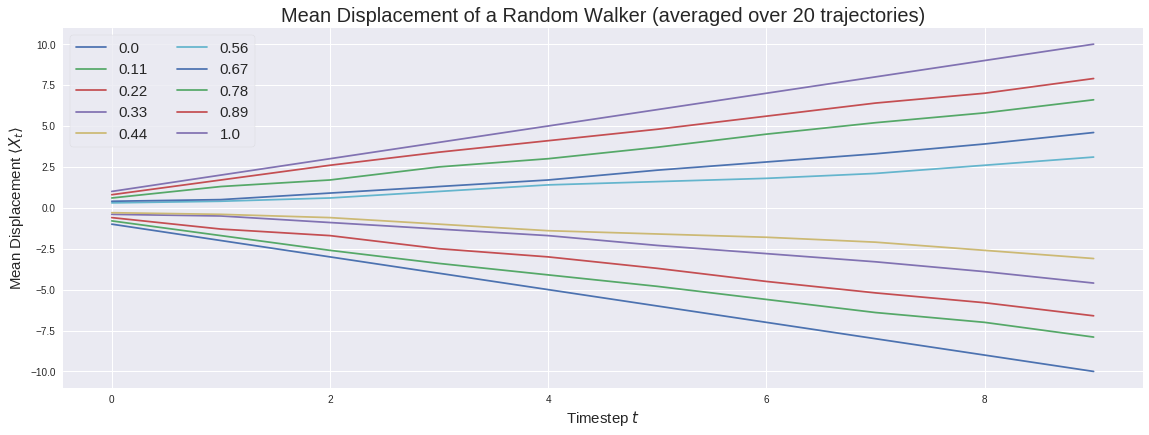

In [224]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_axes([0, 0, 1, 1])

T = 10
numTrajectories = 20
ps = np.linspace(0, 1, num=10)
for p in ps:
    trajs = multiple_trajectories(p, T, numTrajectories)

    mean_traj = np.mean(trajs, axis=0)

    ax.plot(mean_traj, label=np.round(p, 2))
    
ax.legend(fontsize=15,ncol=2, frameon=True, fancybox=True)

ax.set_title('Mean Displacement of a Random Walker (averaged over {0} trajectories)'.format(numTrajectories),\
                                                                                            fontsize=20)
ax.set_xlabel(r'Timestep $t$', fontsize=15)
ax.set_ylabel(r'Mean Displacement $\langle X_{t}\rangle$', fontsize=15)

Using the definition of $X_{T}$, we can compute its expected value analytically:

$$\langle X_{T} \rangle = \sum_{j=1}^{T}\langle \Delta_{j} \rangle = \sum_{j=1}^{T}(1*p -1*(1-p)) = (2p-1)T$$

Looking at our plot above, our simulation conforms to that behavior.

Variance of the Displacement
-------------------------

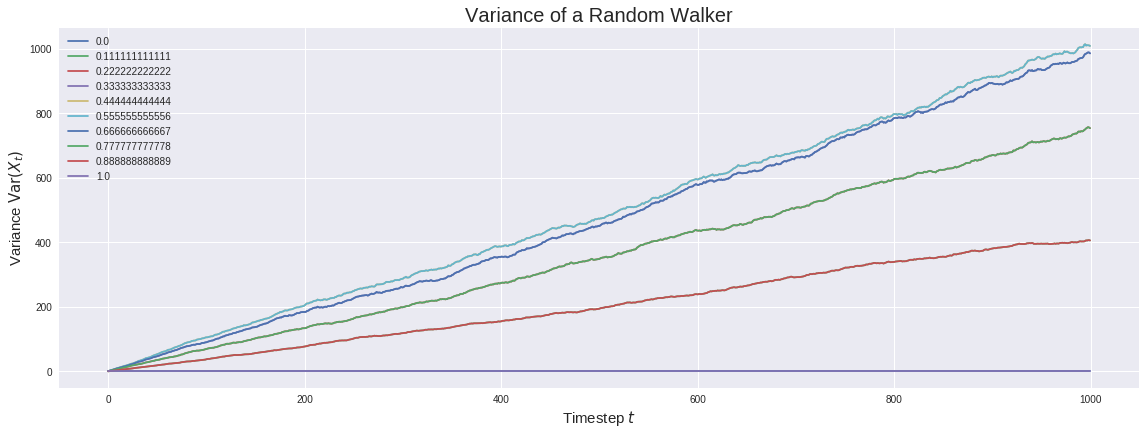

In [206]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_axes([0, 0, 1, 1])

T = 1000

for p in np.linspace(0, 1, num=10):
    trajs = multiple_trajectories(p, T, 1000)

    mean_traj = np.std(trajs, axis=0) ** 2

    ax.plot(mean_traj, label=p)
    
ax.legend()

ax.set_title('Variance of a Random Walker', fontsize=20)
ax.set_xlabel(r'Timestep $t$', fontsize=15)
ax.set_ylabel(r'Variance $\mathrm{Var}(X_{t})$', fontsize=15)

Hmm..that's strange - the number of lines shown on the legend is not the same as the number on the plot? What's going on?

It turns out that the variance of the random walk is _symmetric_ under the exchange $p \rightarrow 1-p$. We can see this by computing the variance of the random walks as a function of $p$, and making a plot.

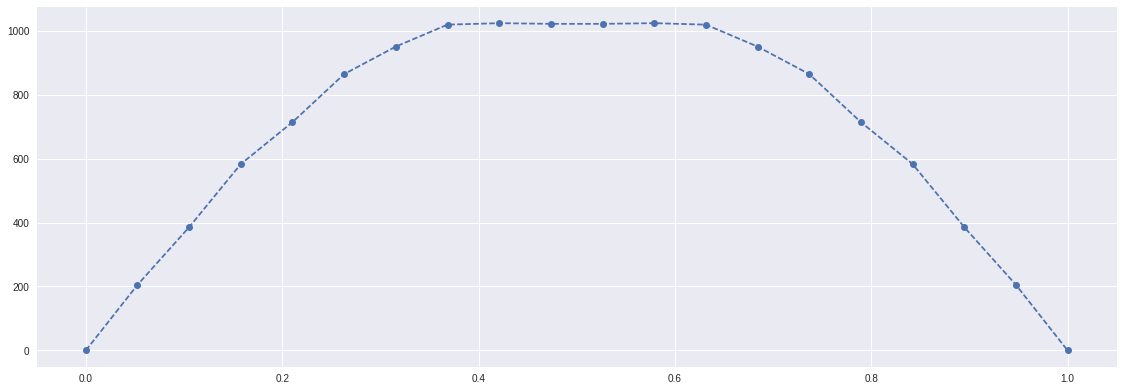

In [198]:
T = 1000

foo = []
ps = np.linspace(0, 1, num=20)
for p in ps:
    trajs = multiple_trajectories(p, T, 1000)

    mean_traj = np.std(trajs, axis=0) ** 2

    foo.append(mean_traj[-1])

fig = plt.figure(figsize=(15, 5))
ax = fig.add_axes([0, 0, 1, 1])

ax.plot(ps, foo, ls='--', marker='o', clip_on=False)

Indeed, it looks like the variance doesn't change when we send $p$ to $1-p$.

We can also see this by computing the variance of $X_{T}$ analytically:
$$\mathrm{Var}(X_{T}) = \sum_{j=1}^{T}\mathrm{Var}(\Delta_{j})= \sum_{j=1}^{T}4p(1-p)= 4p(1-p)T$$

Indeed, this expression is invariant under $p \rightarrow 1-p$. Thus, the code above isn't "wrong" per se, but we only need to plot values for $p \in [0, .5]$ to describe the entire behavior of the walk.

Extensions
========

Here are a few extensions of this lesson which might be of interest:

* Un-vectorize ``compute_value()`` to allow for a random walk where the step sizes to the left and right are different. You may be able to re-vectorize it using ``numpy.vectorize()``.

* Use the simulator to compute the probability $X_{T}$ has some fixed value $x$, as a function of $T$ and $p$. (This is related to the _hitting time_ of the walk.)

* Consider two random walkers who start at different initial positions. What's the probability that one walker overtakes the other after $T$ timesteps, as a function of $p$ and the starting positions?